<a href="https://colab.research.google.com/github/EmmarieR/CNM-DeepDive-Data-Science-Projects/blob/main/Spotify_Emmarieipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Music Popularity Prediction


This project will take data features collected for songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021. The popularity of the song will be predicted using a tree-based regression model trained on these features.



The goals for the project are:

- Minimize the cross-validated ***root mean squared error ( RMSE )*** when predicting the popularity of a new song.

- Determine the importance of the features in driving the regression result.
The project will be done using tree-based regression techniques as covered in class. The hyperparameters of the trees should be carefully selected to avoid over-fitting.


There are three main challenges for this project:

1. Determining the outcome ( i.e. target ).  There is a "popularity" column.  But other columns may or may not be more appropriate indicators of popularity.

1. Choosing appropriate predictors ( i.e. features ). When building a machine learning model, we want to make sure that we consider how the model will be ultimately used. For this project, we are predicting the popularity of a new song. Therefore, we should only include the predictors we would have for a new song. It might help to imagine that the song will not be released for several weeks.

1. Data cleaning and feature engineering. Some creative cleaning and/or feature engineering may be needed to extract useful information for prediction.



Once again, be sure to go through the whole data science process and document as such in your Jupyter notebook.

The data is available AWS at https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv .



In [489]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv"
!curl -s -I {url}

HTTP/1.1 200 OK
x-amz-id-2: GAM7mXsQAIh5eGqJIj41FyWneCxO8tki6Fj6fC6GM6pyxoFJl8lRQdeCpyumAw5WGG9IEJb/lGk=
x-amz-request-id: 7RXC9A0BTKFMG1FB
Date: Fri, 25 Apr 2025 15:37:25 GMT
Last-Modified: Wed, 04 Oct 2023 17:23:56 GMT
ETag: "65b9875b11e0d7ea03ee2af024f45e99"
x-amz-server-side-encryption: AES256
Accept-Ranges: bytes
Content-Type: text/csv
Content-Length: 738124
Server: AmazonS3



In [490]:
!curl -s -O {url}

In [491]:
ls -la

total 11424
drwxr-xr-x 1 root root     4096 Apr 25 09:34 ./
drwxr-xr-x 1 root root     4096 Apr 25 08:05 ../
drwxr-xr-x 4 root root     4096 Apr 23 13:39 .config/
-rw-r--r-- 1 root root 10939442 Apr 25 12:33 rfModel.p
drwxr-xr-x 1 root root     4096 Apr 23 13:39 sample_data/
-rw-r--r-- 1 root root   738124 Apr 25 15:37 Spotify.csv


In [492]:
!head -1 Spotify.csv | tr , '\n' | cat -n

     1	Index
     2	Highest Charting Position
     3	Number of Times Charted
     4	Week of Highest Charting
     5	Song Name
     6	Streams
     7	Artist
     8	Artist Followers
     9	Song ID
    10	Genre
    11	Release Date
    12	Weeks Charted
    13	Popularity
    14	Danceability
    15	Energy
    16	Loudness
    17	Speechiness
    18	Acousticness
    19	Liveness
    20	Tempo
    21	Duration (ms)
    22	Valence
    23	Chord


##Data Collection and Sources

This dataset is provided to us on Amazon via the link above. The dataset is 279.7KB. The dataset contains 1555 rows and 23 data columns. The entries are for each song that charted on the global top 200 list on Spotify from 2020 and 2021. The data columns order data for song name, artist name, genre, music type, and song length. We will employ tree-based regression for building a model to predict song popularity.

###Imports

In [493]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer
import ast
from itertools import chain

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [494]:
# call in csv file as df
spotify = pd.read_csv('Spotify.csv')
spotify.head().T

,0,1,2,3,4
Index,1,2,3,4,5
Highest Charting Position,1,2,1,3,5
Number of Times Charted,8,3,11,5,1
Week of Highest Charting,2021-07-23--2021-07-30,2021-07-23--2021-07-30,2021-06-25--2021-07-02,2021-07-02--2021-07-09,2021-07-23--2021-07-30
Song Name,Beggin',STAY (with Justin Bieber),good 4 u,Bad Habits,INDUSTRY BABY (feat. Jack Harlow)
Streams,"48,633,449","47,248,719","40,162,559","37,799,456","33,948,454"
Artist,Måneskin,The Kid LAROI,Olivia Rodrigo,Ed Sheeran,Lil Nas X
Artist Followers,3377762,2230022,6266514,83293380,5473565
Song ID,3Wrjm47oTz2sjIgck11l5e,5HCyWlXZPP0y6Gqq8TgA20,4ZtFanR9U6ndgddUvNcjcG,6PQ88X9TkUIAUIZJHW2upE,27NovPIUIRrOZoCHxABJwK
Genre,"['indie rock italiano', 'italian pop']",['australian hip hop'],['pop'],"['pop', 'uk pop']","['lgbtq+ hip hop', 'pop rap']"


In [495]:
# look at df info
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

Things to note: we can probably dump the index column, song name, and song ID. Convert streams, artist followers, duration, popularity? to ints. Convert week of highest charting, release date, weeks charted, to dates. Convert danceability, energy, loudness, speechiness, acousticness, liveness, tempo, valence to floats (encode and scale?). Encode for artist, genre, and chord. Extract generes from dicts and one-hot encode each genre.

another thing to note: may go in and trim the genres to single types, eg. austrailian pop & italian pop = pop

## Data Cleaning

In [496]:
# look for nulls
spotify.isnull().sum()

,0
Index,0
Highest Charting Position,0
Number of Times Charted,0
Week of Highest Charting,0
Song Name,0
Streams,0
Artist,0
Artist Followers,0
Song ID,0
Genre,0


wow no nulls :) or are there?

##Drop Identifiers

In [497]:
# look for unique columns
spotify.nunique()

,0
Index,1556
Highest Charting Position,200
Number of Times Charted,75
Week of Highest Charting,83
Song Name,1556
Streams,1556
Artist,716
Artist Followers,600
Song ID,1517
Genre,395


why are there repeats in the song ID column??

In [498]:
# find repeated song IDs
spotify[spotify.duplicated(subset=['Song ID'])].sort_values(by=['Song ID'])


,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
750,751,19,20,2020-07-31--2020-08-07,"Agua (with J Balvin) - Music From ""Sponge On T...","5,358,940",Tainy,,,,...,,,,,,,,,,
784,785,76,14,2020-09-04--2020-09-11,"Lean (feat. Towy, Osquel, Beltito & Sammy & Fa...","4,739,241","Super Yei, Jone Quest",,,,...,,,,,,,,,,
654,655,73,1,2020-12-18--2020-12-25,Thank God It's Christmas - Non-Album Single,"10,509,961",Queen,,,,...,,,,,,,,,,
636,637,22,6,2020-12-18--2020-12-25,Driving Home for Christmas - 2019 Remaster,"8,804,531",Chris Rea,,,,...,,,,,,,,,,
530,531,20,5,2021-01-15--2021-01-22,"34+35 Remix (feat. Doja Cat, Megan Thee Stalli...","6,162,453",Ariana Grande,,,,...,,,,,,,,,,
464,465,118,1,2021-03-26--2021-04-02,Richer (feat. Polo G),"6,292,362",Rod Wave,,,,...,,,,,,,,,,
1140,1141,131,1,2020-05-29--2020-06-05,In meinem Benz,"5,494,500","AK AUSSERKONTROLLE, Bonez MC",,,,...,,,,,,,,,,
876,877,164,4,2020-09-18--2020-09-25,+Linda,"4,964,708",Dalex,,,,...,,,,,,,,,,
163,164,5,39,2020-10-30--2020-11-06,34+35,"5,453,159",Ariana Grande,,,,...,,,,,,,,,,
1538,1539,176,1,2020-01-03--2020-01-10,"fuck, i'm lonely (with Anne-Marie) - from “13 ...","4,856,458",Lauv,,,,...,,,,,,,,,,


In [499]:
# look for ariana grande in artist
spotify[spotify['Artist'] == 'Ariana Grande']

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
91,92,1,40,2020-10-30--2020-11-06,positions,"7,244,853",Ariana Grande,67158068,35mvY5S1H3J2QZyna3TFe0,"['dance pop', 'pop', 'post-teen pop']",...,0.737,0.802,-4.771,0.0878,0.468,0.0931,144.015,172325,0.682,C
163,164,5,39,2020-10-30--2020-11-06,34+35,"5,453,159",Ariana Grande,,,,...,,,,,,,,,,
192,193,41,81,2019-12-27--2020-01-03,7 rings,"5,002,227",Ariana Grande,67158068,6ocbgoVGwYJhOv1GgI9NsF,"['dance pop', 'pop', 'post-teen pop']",...,0.778,0.317,-10.732,0.334,0.592,0.0881,140.048,178627,0.327,C#/Db
454,455,2,48,2020-05-08--2020-05-15,Stuck with U (with Justin Bieber),"5,094,660",Ariana Grande,67208170,4HBZA5flZLE435QTztThqH,"['dance pop', 'pop', 'post-teen pop']",...,0.597,0.45,-6.658,0.0418,0.223,0.382,178.765,228482,0.537,G#/Ab
518,519,38,2,2021-02-19--2021-02-26,test drive,"6,591,829",Ariana Grande,67208170,3eZYOQO4UzKrUDYDghtnFw,"['dance pop', 'pop', 'post-teen pop']",...,0.698,0.708,-4.943,0.0454,0.0251,0.124,115.036,122174,0.322,A
530,531,20,5,2021-01-15--2021-01-22,"34+35 Remix (feat. Doja Cat, Megan Thee Stalli...","6,162,453",Ariana Grande,,,,...,,,,,,,,,,
540,541,14,5,2020-10-30--2020-11-06,motive (with Doja Cat),"4,986,037",Ariana Grande,67208170,5GkQIP5mWPi4KZLLXeuFTT,"['dance pop', 'pop', 'post-teen pop']",...,0.789,0.742,-5.664,0.0652,0.0681,0.166,116.965,167990,0.661,A#/Bb
566,567,20,15,2020-11-13--2020-11-20,pov,"4,906,738",Ariana Grande,67208170,3UoULw70kMsiVXxW0L3A33,"['dance pop', 'pop', 'post-teen pop']",...,0.487,0.534,-5.664,0.0555,0.36,0.1,131.798,201882,0.173,C
621,622,3,7,2020-12-18--2020-12-25,Santa Tell Me,"16,657,592",Ariana Grande,67208170,0lizgQ7Qw35od7CYaoMBZb,"['dance pop', 'pop', 'post-teen pop']",...,0.525,0.621,-7.364,0.116,0.0489,0.294,191.9,204093,0.591,G
771,772,20,3,2020-10-30--2020-11-06,off the table (with The Weeknd),"5,308,945",Ariana Grande,67208170,7E1jVNoWuemqUryI4FxsVD,"['dance pop', 'pop', 'post-teen pop']",...,0.411,0.522,-7.295,0.0981,0.519,0.398,88.332,239949,0.382,C


Odd that a handful of entries have blanks for some of the column entries, but are not considered null.

Let's delete any rows that have blank entries in their data columns.

In [500]:
# Replace blank strings with nulls
spotify.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# find nulls in df
spotify.isnull().sum()

,0
Index,0
Highest Charting Position,0
Number of Times Charted,0
Week of Highest Charting,0
Song Name,0
Streams,0
Artist,0
Artist Followers,11
Song ID,11
Genre,11


In [501]:
# delete rows with nulls and save new df copy
spotify_clean = spotify.dropna().copy()
spotify_clean.isnull().sum()

,0
Index,0
Highest Charting Position,0
Number of Times Charted,0
Week of Highest Charting,0
Song Name,0
Streams,0
Artist,0
Artist Followers,0
Song ID,0
Genre,0


In [502]:
# look for ariana grande in artist
spotify_clean[spotify_clean['Artist'] == 'Ariana Grande']

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
91,92,1,40,2020-10-30--2020-11-06,positions,"7,244,853",Ariana Grande,67158068,35mvY5S1H3J2QZyna3TFe0,"['dance pop', 'pop', 'post-teen pop']",...,0.737,0.802,-4.771,0.0878,0.468,0.0931,144.015,172325,0.682,C
192,193,41,81,2019-12-27--2020-01-03,7 rings,"5,002,227",Ariana Grande,67158068,6ocbgoVGwYJhOv1GgI9NsF,"['dance pop', 'pop', 'post-teen pop']",...,0.778,0.317,-10.732,0.334,0.592,0.0881,140.048,178627,0.327,C#/Db
454,455,2,48,2020-05-08--2020-05-15,Stuck with U (with Justin Bieber),"5,094,660",Ariana Grande,67208170,4HBZA5flZLE435QTztThqH,"['dance pop', 'pop', 'post-teen pop']",...,0.597,0.45,-6.658,0.0418,0.223,0.382,178.765,228482,0.537,G#/Ab
518,519,38,2,2021-02-19--2021-02-26,test drive,"6,591,829",Ariana Grande,67208170,3eZYOQO4UzKrUDYDghtnFw,"['dance pop', 'pop', 'post-teen pop']",...,0.698,0.708,-4.943,0.0454,0.0251,0.124,115.036,122174,0.322,A
540,541,14,5,2020-10-30--2020-11-06,motive (with Doja Cat),"4,986,037",Ariana Grande,67208170,5GkQIP5mWPi4KZLLXeuFTT,"['dance pop', 'pop', 'post-teen pop']",...,0.789,0.742,-5.664,0.0652,0.0681,0.166,116.965,167990,0.661,A#/Bb
566,567,20,15,2020-11-13--2020-11-20,pov,"4,906,738",Ariana Grande,67208170,3UoULw70kMsiVXxW0L3A33,"['dance pop', 'pop', 'post-teen pop']",...,0.487,0.534,-5.664,0.0555,0.36,0.1,131.798,201882,0.173,C
621,622,3,7,2020-12-18--2020-12-25,Santa Tell Me,"16,657,592",Ariana Grande,67208170,0lizgQ7Qw35od7CYaoMBZb,"['dance pop', 'pop', 'post-teen pop']",...,0.525,0.621,-7.364,0.116,0.0489,0.294,191.9,204093,0.591,G
771,772,20,3,2020-10-30--2020-11-06,off the table (with The Weeknd),"5,308,945",Ariana Grande,67208170,7E1jVNoWuemqUryI4FxsVD,"['dance pop', 'pop', 'post-teen pop']",...,0.411,0.522,-7.295,0.0981,0.519,0.398,88.332,239949,0.382,C
778,779,25,3,2020-10-30--2020-11-06,just like magic,"4,980,571",Ariana Grande,67208170,7Dx9Z6Aon1qPS2N0rHSWTe,"['dance pop', 'pop', 'post-teen pop']",...,0.719,0.607,-5.156,0.165,0.08,0.125,128.006,149900,0.464,G#/Ab
789,790,38,2,2020-10-30--2020-11-06,safety net (feat. Ty Dolla $ign),"5,798,744",Ariana Grande,67208170,14gkWVFMwdxBMyqBw1wmIg,"['dance pop', 'pop', 'post-teen pop']",...,0.552,0.599,-5.75,0.0404,0.0703,0.0986,161.884,208457,0.0916,C#/Db


Looks better. Let's drop the ID columns now.

In [503]:
# drop Index, Song Name, and Song ID.
spotify_clean.drop(columns=['Index', 'Song Name', 'Song ID'], inplace=True)


In [504]:
spotify_clean.head()

,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Streams,Artist,Artist Followers,Genre,Release Date,Weeks Charted,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,8,2021-07-23--2021-07-30,"48,633,449",Måneskin,3377762,"['indie rock italiano', 'italian pop']",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,100,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,3,2021-07-23--2021-07-30,"47,248,719",The Kid LAROI,2230022,['australian hip hop'],2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,1,11,2021-06-25--2021-07-02,"40,162,559",Olivia Rodrigo,6266514,['pop'],2021-05-21,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,3,5,2021-07-02--2021-07-09,"37,799,456",Ed Sheeran,83293380,"['pop', 'uk pop']",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,98,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,1,2021-07-23--2021-07-30,"33,948,454",Lil Nas X,5473565,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,2021-07-23--2021-07-30,96,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


For now, let's delete the popularity, week of highest charting, and weeks charted columns. They could be possibly used as a 'success' metric, but seems too complicated at the moment to integrate those into a popularity score. Let's convert the rest of the date like columns to have date data types.

In [505]:
# drop Week of highehest charting and Weeks charted
spotify_clean.drop(columns=['Week of Highest Charting', 'Weeks Charted', 'Popularity'], inplace=True)
spotify_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Highest Charting Position  1545 non-null   int64 
 1   Number of Times Charted    1545 non-null   int64 
 2   Streams                    1545 non-null   object
 3   Artist                     1545 non-null   object
 4   Artist Followers           1545 non-null   object
 5   Genre                      1545 non-null   object
 6   Release Date               1545 non-null   object
 7   Danceability               1545 non-null   object
 8   Energy                     1545 non-null   object
 9   Loudness                   1545 non-null   object
 10  Speechiness                1545 non-null   object
 11  Acousticness               1545 non-null   object
 12  Liveness                   1545 non-null   object
 13  Tempo                      1545 non-null   object
 14  Duration (ms)

In [506]:
# convert release date to date data type
spotify_clean['Release Date'] = pd.to_datetime(spotify_clean['Release Date'], errors='coerce', format='%Y-%m-%d') # convert with specified format, handle errors
spotify_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Highest Charting Position  1545 non-null   int64         
 1   Number of Times Charted    1545 non-null   int64         
 2   Streams                    1545 non-null   object        
 3   Artist                     1545 non-null   object        
 4   Artist Followers           1545 non-null   object        
 5   Genre                      1545 non-null   object        
 6   Release Date               1528 non-null   datetime64[ns]
 7   Danceability               1545 non-null   object        
 8   Energy                     1545 non-null   object        
 9   Loudness                   1545 non-null   object        
 10  Speechiness                1545 non-null   object        
 11  Acousticness               1545 non-null   object        
 12  Liveness   

In [507]:
# place release month and day into their own columns
spotify_clean['Release Month'] = spotify_clean['Release Date'].dt.month
spotify_clean['Release Day'] = spotify_clean['Release Date'].dt.day
spotify_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Highest Charting Position  1545 non-null   int64         
 1   Number of Times Charted    1545 non-null   int64         
 2   Streams                    1545 non-null   object        
 3   Artist                     1545 non-null   object        
 4   Artist Followers           1545 non-null   object        
 5   Genre                      1545 non-null   object        
 6   Release Date               1528 non-null   datetime64[ns]
 7   Danceability               1545 non-null   object        
 8   Energy                     1545 non-null   object        
 9   Loudness                   1545 non-null   object        
 10  Speechiness                1545 non-null   object        
 11  Acousticness               1545 non-null   object        
 12  Liveness   

In [508]:
# remove release date column
spotify_clean.drop(columns=['Release Date'], inplace=True)
spotify_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Highest Charting Position  1545 non-null   int64  
 1   Number of Times Charted    1545 non-null   int64  
 2   Streams                    1545 non-null   object 
 3   Artist                     1545 non-null   object 
 4   Artist Followers           1545 non-null   object 
 5   Genre                      1545 non-null   object 
 6   Danceability               1545 non-null   object 
 7   Energy                     1545 non-null   object 
 8   Loudness                   1545 non-null   object 
 9   Speechiness                1545 non-null   object 
 10  Acousticness               1545 non-null   object 
 11  Liveness                   1545 non-null   object 
 12  Tempo                      1545 non-null   object 
 13  Duration (ms)              1545 non-null   object 
 1

Next, let's convert streams, followers, duration, valence, and all the other scored columns to numerical data types.

In [509]:
# convert streams, artist followers, and duration to ints
spotify_clean['Streams'] = spotify_clean['Streams'].astype(str).str.replace(',', '').astype(int)
spotify_clean['Artist Followers'] = spotify_clean['Artist Followers'].astype(int)
spotify_clean['Duration (ms)'] = spotify_clean['Duration (ms)'].astype(int)
spotify_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Highest Charting Position  1545 non-null   int64  
 1   Number of Times Charted    1545 non-null   int64  
 2   Streams                    1545 non-null   int64  
 3   Artist                     1545 non-null   object 
 4   Artist Followers           1545 non-null   int64  
 5   Genre                      1545 non-null   object 
 6   Danceability               1545 non-null   object 
 7   Energy                     1545 non-null   object 
 8   Loudness                   1545 non-null   object 
 9   Speechiness                1545 non-null   object 
 10  Acousticness               1545 non-null   object 
 11  Liveness                   1545 non-null   object 
 12  Tempo                      1545 non-null   object 
 13  Duration (ms)              1545 non-null   int64  
 1

In [510]:
# convert danceability, energy, loudness, speechiness, acousticness, liveness, tempo, and valence to floats
spotify_clean['Danceability'] = spotify_clean['Danceability'].astype(float)
spotify_clean['Energy'] = spotify_clean['Energy'].astype(float)
spotify_clean['Loudness'] = spotify_clean['Loudness'].astype(float)
spotify_clean['Speechiness'] = spotify_clean['Speechiness'].astype(float)
spotify_clean['Acousticness'] = spotify_clean['Acousticness'].astype(float)
spotify_clean['Liveness'] = spotify_clean['Liveness'].astype(float)
spotify_clean['Tempo'] = spotify_clean['Tempo'].astype(float)
spotify_clean['Valence'] = spotify_clean['Valence'].astype(float)
spotify_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Highest Charting Position  1545 non-null   int64  
 1   Number of Times Charted    1545 non-null   int64  
 2   Streams                    1545 non-null   int64  
 3   Artist                     1545 non-null   object 
 4   Artist Followers           1545 non-null   int64  
 5   Genre                      1545 non-null   object 
 6   Danceability               1545 non-null   float64
 7   Energy                     1545 non-null   float64
 8   Loudness                   1545 non-null   float64
 9   Speechiness                1545 non-null   float64
 10  Acousticness               1545 non-null   float64
 11  Liveness                   1545 non-null   float64
 12  Tempo                      1545 non-null   float64
 13  Duration (ms)              1545 non-null   int64  
 1

In [511]:
# save a copy df
spotify_clean2 = spotify_clean.copy()

For now, I am going to drop the artist, genere, and chord columns, as they will take extra time to encode for. I may add these back in to the model later on.

In [512]:
# drop artist, genre, and chord
spotify_clean2.drop(columns=['Artist', 'Genre', 'Chord'], inplace=True)
spotify_clean2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Highest Charting Position  1545 non-null   int64  
 1   Number of Times Charted    1545 non-null   int64  
 2   Streams                    1545 non-null   int64  
 3   Artist Followers           1545 non-null   int64  
 4   Danceability               1545 non-null   float64
 5   Energy                     1545 non-null   float64
 6   Loudness                   1545 non-null   float64
 7   Speechiness                1545 non-null   float64
 8   Acousticness               1545 non-null   float64
 9   Liveness                   1545 non-null   float64
 10  Tempo                      1545 non-null   float64
 11  Duration (ms)              1545 non-null   int64  
 12  Valence                    1545 non-null   float64
 13  Release Month              1528 non-null   float64
 1

##Exploratory Data Analysis

Let's make some quick visualizations of the data.

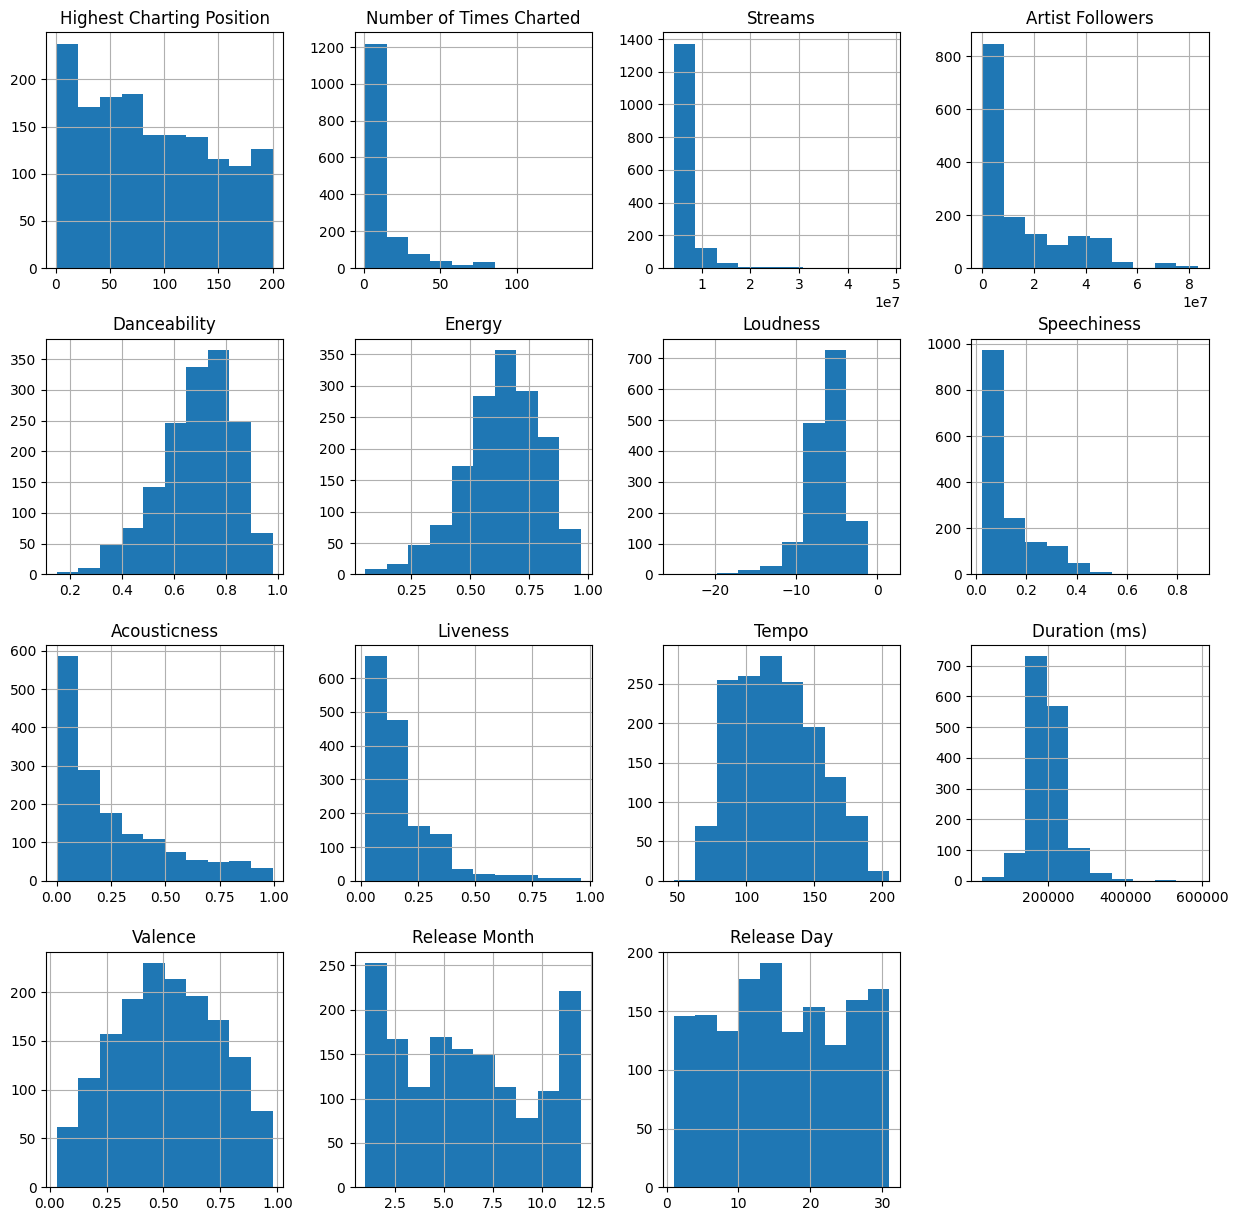

In [513]:
# histograms
spotify_clean2.hist(figsize=(15,15));

I want to downselect on which data column to use for my popularity indicator. I am going to choose either highest charting position, number of times charted, or streams. Steams and number of times charted seem to have highly skewed distributions, so they may be more difficult to use for the model. For now, let's go with highest charting position.

I am curious to see the linear correlation between our current data points

<Axes: >

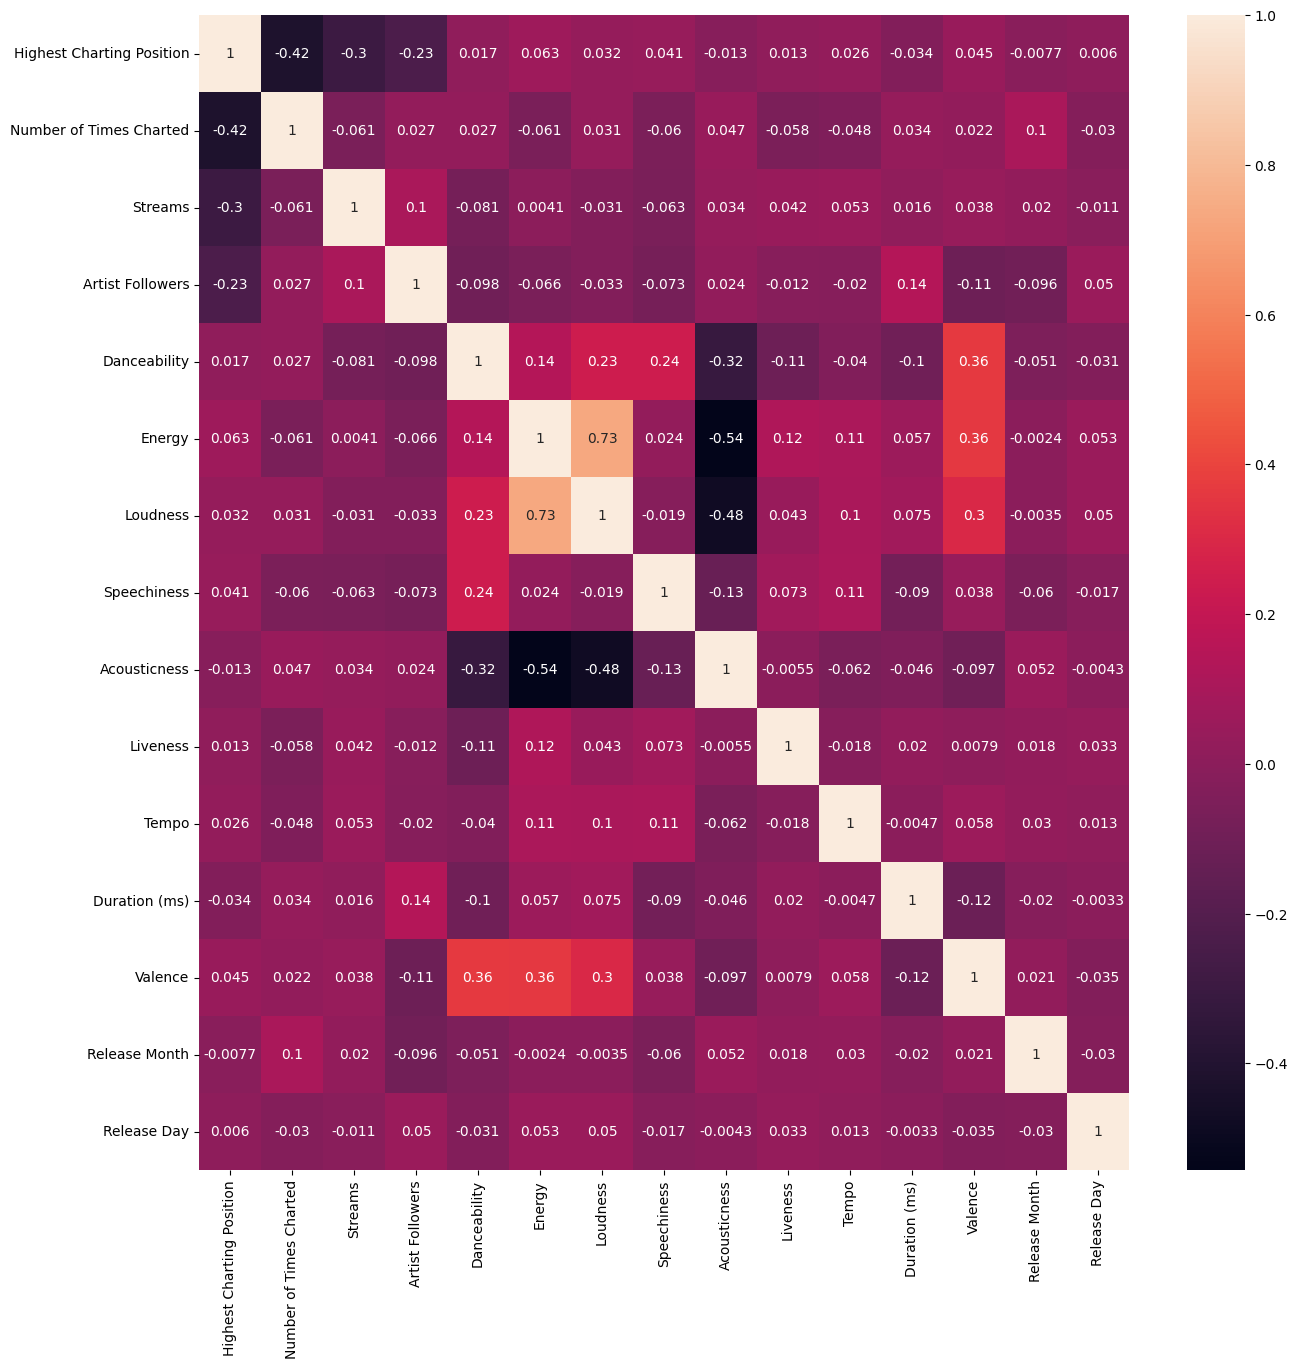

In [514]:
# correlation matrix figure
plt.figure(figsize=(15,15))
sns.heatmap(spotify_clean2.corr(), annot=True)

Not really seeing great linear relationships, but this shouldn't matter for a random forest prediction model.

## Data Processing

Let's get started on the first iteration of the prediction modeling.

In [515]:
# drop number of times charted and streams
spotify_clean2.drop(columns=['Number of Times Charted', 'Streams'], inplace=True)
spotify_clean2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Highest Charting Position  1545 non-null   int64  
 1   Artist Followers           1545 non-null   int64  
 2   Danceability               1545 non-null   float64
 3   Energy                     1545 non-null   float64
 4   Loudness                   1545 non-null   float64
 5   Speechiness                1545 non-null   float64
 6   Acousticness               1545 non-null   float64
 7   Liveness                   1545 non-null   float64
 8   Tempo                      1545 non-null   float64
 9   Duration (ms)              1545 non-null   int64  
 10  Valence                    1545 non-null   float64
 11  Release Month              1528 non-null   float64
 12  Release Day                1528 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 169.0 KB


###Decision Tree Regression

In [516]:
# call X and y
X = spotify_clean2.drop(columns=['Highest Charting Position'])
y = spotify_clean2['Highest Charting Position']

In [517]:
numLoops = 500

mean_error = np.zeros(numLoops)

np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor(max_depth=4, random_state=0)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  mean_error[idx] = mean_squared_error(y_test, y_pred)

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')

RMSE: 57.45555159546822
RMSE_std: 1.7033309845435172


###Random Forest

In [518]:
# two parameters - n_estimators (number of trees), max_depth (number of splits)
numLoops = 500

mean_error = np.zeros(numLoops)

# np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )
  model = RandomForestRegressor( n_estimators = 10 ) #n_estimators is number of trees in forest. Note: you can also choose max_depth for RFs
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  mean_error[idx] = mean_squared_error( y_test, y_pred )

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')
np.sqrt(mean_error)[:50]


RMSE: 57.9978377645738
RMSE_std: 1.7943763693729917


array([58.93921339, 58.15777447, 54.72759866, 55.49416853, 53.71946381,
       57.42301583, 58.1670665 , 58.1098461 , 57.72217094, 57.0949136 ,
       58.47853022, 56.35050331, 56.79597622, 57.72523213, 57.40161703,
       56.93240196, 59.67003675, 58.76075726, 55.1297781 , 59.50325756,
       55.11959533, 57.4139549 , 58.62694385, 59.40004129, 60.04726541,
       57.89509419, 57.34960617, 57.19032292, 58.39275438, 55.98701174,
       58.67426365, 58.5871549 , 55.56455064, 57.12497319, 58.08449825,
       57.18206705, 58.17510112, 58.67953004, 57.01631566, 57.06556199,
       61.1192614 , 55.90744598, 58.76119514, 54.75906397, 55.62554326,
       56.97456936, 57.49335407, 60.05994613, 57.61055424, 58.02269882])

In [519]:
num_trees = range(10,70,10)
cv_loops = 100
rmse_results = np.zeros(len(num_trees))
std_results = np.zeros(len(num_trees))

for n, trees in enumerate(num_trees):
  rmse_cv = np.zeros(cv_loops)
  np.random.seed(42)
  for i in range(cv_loops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
    rfModel = RandomForestRegressor( n_estimators=trees )
    rfModel.fit(X_train, y_train)
    y_pred_rf = rfModel.predict(X_test)
    rmse_cv[i] = np.sqrt(mean_squared_error(y_test, y_pred_rf))

  print(trees,' trees finished.')
  rmse_results[n] = rmse_cv.mean()
  std_results[n] = rmse_cv.std()


10  trees finished.
20  trees finished.
30  trees finished.
40  trees finished.
50  trees finished.
60  trees finished.


## Data Visulaization

### First pass RMSE plots

In [520]:
pickle.dump(rfModel, open('rfModel.p','wb'))


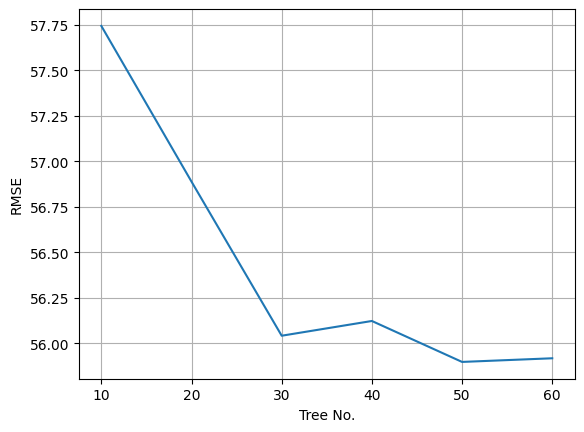

In [521]:
plt.plot(num_trees, rmse_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')
plt.grid()

In [522]:
pd.DataFrame( zip( rmse_results, std_results, ) )


,0,1
0,57.742728,1.697235
1,56.887906,1.511775
2,56.041905,1.760750
3,56.122824,1.667057
4,55.898056,1.672942
5,55.918057,1.454435


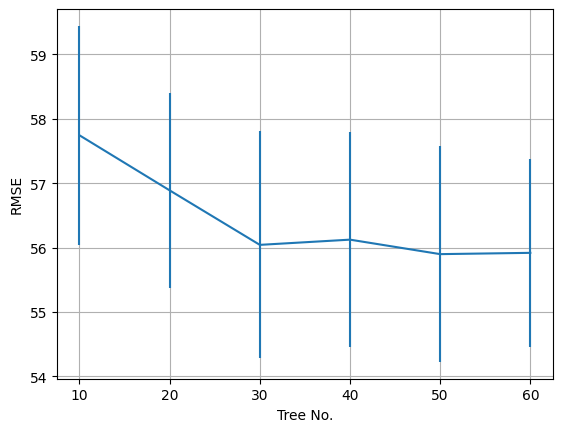

In [523]:
# plt.errorbar(num_trees, rmse_results, yerr=(std_results*2,std_results*2))
plt.errorbar(num_trees, rmse_results, yerr=std_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')

plt.grid()


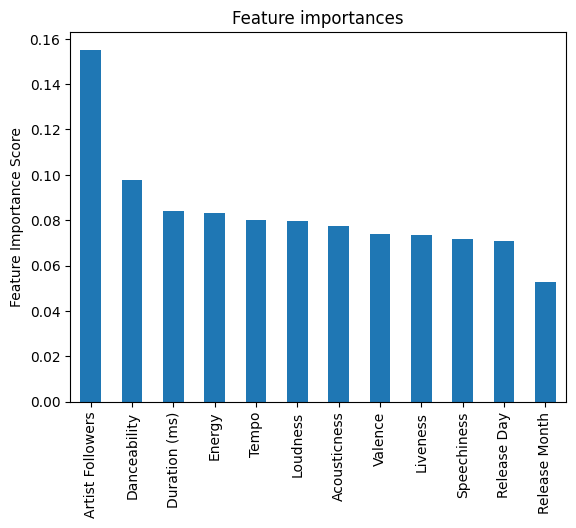

In [524]:
importances = rfModel.feature_importances_
forest_importances = pd.Series( importances, index = X.columns )

plt.figure()
# forest_importances.plot.bar()
forest_importances.sort_values( ascending = False ).plot.bar()
plt.title("Feature importances")
plt.ylabel('Feature Importance Score') ;


cool, so our working RMSE is ~55-56 chart positions. Let's see if adding back in some encodeable variables helps or harms the model.

## Data Processing V2

### Encoding

let's start with the artists. It looks like there is one or more artists listed per entry, with multiples being separated by a comma. Let's split the artist names, then one-hot encode all of the unique names for each song.

In [525]:
# split names in artist name column
spotify_clean['Artist'] = spotify_clean['Artist'].str.split(',')
spotify_clean.head(50)

,Highest Charting Position,Number of Times Charted,Streams,Artist,Artist Followers,Genre,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord,Release Month,Release Day
0,1,8,48633449,[Måneskin],3377762,"['indie rock italiano', 'italian pop']",0.714,0.800,-4.808,0.0504,0.12700,0.3590,134.002,211560,0.5890,B,12.0,8.0
1,2,3,47248719,[The Kid LAROI],2230022,['australian hip hop'],0.591,0.764,-5.484,0.0483,0.03830,0.1030,169.928,141806,0.4780,C#/Db,7.0,9.0
2,1,11,40162559,[Olivia Rodrigo],6266514,['pop'],0.563,0.664,-5.044,0.1540,0.33500,0.0849,166.928,178147,0.6880,A,5.0,21.0
3,3,5,37799456,[Ed Sheeran],83293380,"['pop', 'uk pop']",0.808,0.897,-3.712,0.0348,0.04690,0.3640,126.026,231041,0.5910,B,6.0,25.0
4,5,1,33948454,[Lil Nas X],5473565,"['lgbtq+ hip hop', 'pop rap']",0.736,0.704,-7.409,0.0615,0.02030,0.0501,149.995,212000,0.8940,D#/Eb,7.0,23.0
5,1,18,30071134,[Lil Nas X],5473565,"['lgbtq+ hip hop', 'pop rap']",0.610,0.508,-6.682,0.1520,0.29700,0.3840,178.818,137876,0.7580,G#/Ab,3.0,31.0
6,3,16,29356736,[Doja Cat],8640063,"['dance pop', 'pop']",0.762,0.701,-3.541,0.0286,0.23500,0.1230,110.968,208867,0.7420,G#/Ab,4.0,9.0
7,2,10,26951613,[Rauw Alejandro],6080597,"['puerto rican pop', 'trap latino']",0.780,0.718,-3.605,0.0506,0.31000,0.0932,127.949,199604,0.3420,D#/Eb,5.0,20.0
8,3,8,25030128,[Bad Bunny],36142273,"['latin', 'reggaeton', 'trap latino']",0.644,0.648,-4.601,0.1180,0.27600,0.1350,179.951,206710,0.4400,C#/Db,6.0,4.0
9,8,10,24551591,[Måneskin],3377762,"['indie rock italiano', 'italian pop']",0.750,0.608,-4.008,0.0387,0.00165,0.1780,132.507,173347,0.9580,C#/Db,3.0,19.0


In [526]:
# one-hot encode for artist name
mlb = MultiLabelBinarizer()
spotify_encoded = spotify_clean.join(pd.DataFrame(mlb.fit_transform(spotify_clean.pop('Artist')),
                          columns=mlb.classes_,
                          index=spotify_clean.index))

In [527]:
spotify_encoded.head()

,Highest Charting Position,Number of Times Charted,Streams,Artist Followers,Genre,Danceability,Energy,Loudness,Speechiness,Acousticness,...,Zuna,a-ha,benny blanco,blackbear,dhruv,iann dior,jxdn,salem ilese,sangiovanni,twocolors
0,1,8,48633449,3377762,"['indie rock italiano', 'italian pop']",0.714,0.800,-4.808,0.0504,0.1270,...,0,0,0,0,0,0,0,0,0,0
1,2,3,47248719,2230022,['australian hip hop'],0.591,0.764,-5.484,0.0483,0.0383,...,0,0,0,0,0,0,0,0,0,0
2,1,11,40162559,6266514,['pop'],0.563,0.664,-5.044,0.1540,0.3350,...,0,0,0,0,0,0,0,0,0,0
3,3,5,37799456,83293380,"['pop', 'uk pop']",0.808,0.897,-3.712,0.0348,0.0469,...,0,0,0,0,0,0,0,0,0,0
4,5,1,33948454,5473565,"['lgbtq+ hip hop', 'pop rap']",0.736,0.704,-7.409,0.0615,0.0203,...,0,0,0,0,0,0,0,0,0,0


Next, let's do the genres. I'll start by making a list of all the unique genres and see if I can manually sort some of them into more general genres.

In [528]:
# list of genres
spotify_encoded['Genre'].unique()


array(["['indie rock italiano', 'italian pop']", "['australian hip hop']",
       "['pop']", "['pop', 'uk pop']", "['lgbtq+ hip hop', 'pop rap']",
       "['dance pop', 'pop']", "['puerto rican pop', 'trap latino']",
       "['latin', 'reggaeton', 'trap latino']",
       "['dance pop', 'pop', 'uk pop']",
       "['latin', 'reggaeton', 'reggaeton colombiano']",
       "['k-pop', 'k-pop boy group']",
       "['canadian pop', 'pop', 'post-teen pop']",
       "['canadian contemporary r&b', 'canadian pop', 'pop']",
       "['reggaeton', 'trap latino']",
       "['gauze pop', 'indietronica', 'shiver pop']",
       "['latin', 'latin hip hop', 'reggaeton', 'trap latino']",
       "['dfw rap', 'melodic rap', 'rap']",
       "['dance pop', 'house', 'pop dance', 'tropical house', 'uk dance']",
       "['dance pop', 'pop', 'post-teen pop']",
       "['dance pop', 'electropop', 'pop', 'post-teen pop']",
       "['colombian pop', 'latin', 'reggaeton', 'reggaeton colombiano']",
       "['pop', 'post-

In [529]:
# make genric genre columns in df
spotify_encoded['Pop'] = np.where(spotify_encoded['Genre'].str.contains('pop'), 1, 0)
spotify_encoded['Rock'] = np.where(spotify_encoded['Genre'].str.contains('rock'), 1, 0)
spotify_encoded['Rap'] = np.where(spotify_encoded['Genre'].str.contains('ap'), 1, 0)
spotify_encoded['R&B'] = np.where(spotify_encoded['Genre'].str.contains('r&b'), 1, 0)
spotify_encoded['Country'] = np.where(spotify_encoded['Genre'].str.contains('country'), 1, 0)
spotify_encoded['Electronic'] = np.where(spotify_encoded['Genre'].str.contains('electro'), 1, 0)
spotify_encoded['Latin'] = np.where(spotify_encoded['Genre'].str.contains('latin'), 1, 0)
spotify_encoded['Folk'] = np.where(spotify_encoded['Genre'].str.contains('folk'), 1, 0)
spotify_encoded['Hip Hop'] = np.where(spotify_encoded['Genre'].str.contains('hip hop'), 1, 0)
spotify_encoded['Indie'] = np.where(spotify_encoded['Genre'].str.contains('indie'), 1, 0)
spotify_encoded['Jazz'] = np.where(spotify_encoded['Genre'].str.contains('jazz'), 1, 0)
spotify_encoded['Metal'] = np.where(spotify_encoded['Genre'].str.contains('metal'), 1, 0)
spotify_encoded['Soul'] = np.where(spotify_encoded['Genre'].str.contains('soul'), 1, 0)


In [530]:
spotify_encoded['Pop'].value_counts()

,count
Pop,
1,819
0,726


Finally, let's encode for chord.

In [531]:
# list of chords
spotify_encoded['Chord'].unique()


array(['B', 'C#/Db', 'A', 'D#/Eb', 'G#/Ab', 'F#/Gb', 'C', 'D', 'A#/Bb',
       'G', 'E', 'F'], dtype=object)

In [532]:
# one-hot encode for chord column
mlb = MultiLabelBinarizer()
spotify_encoded = spotify_encoded.join(pd.DataFrame(mlb.fit_transform(spotify_encoded.pop('Chord')),
                          columns=mlb.classes_,
                          index=spotify_encoded.index))

In [533]:
spotify_encoded.head()

,Highest Charting Position,Number of Times Charted,Streams,Artist Followers,Genre,Danceability,Energy,Loudness,Speechiness,Acousticness,...,#,/,A,B,C,D,E,F,G,b
0,1,8,48633449,3377762,"['indie rock italiano', 'italian pop']",0.714,0.800,-4.808,0.0504,0.1270,...,0,0,0,1,0,0,0,0,0,0
1,2,3,47248719,2230022,['australian hip hop'],0.591,0.764,-5.484,0.0483,0.0383,...,1,1,0,0,1,1,0,0,0,1
2,1,11,40162559,6266514,['pop'],0.563,0.664,-5.044,0.1540,0.3350,...,0,0,1,0,0,0,0,0,0,0
3,3,5,37799456,83293380,"['pop', 'uk pop']",0.808,0.897,-3.712,0.0348,0.0469,...,0,0,0,1,0,0,0,0,0,0
4,5,1,33948454,5473565,"['lgbtq+ hip hop', 'pop rap']",0.736,0.704,-7.409,0.0615,0.0203,...,1,1,0,0,0,1,1,0,0,1


In [534]:
# delete genre, streams, and number of times charted column
spotify_encoded.drop(columns=['Genre', 'Streams', 'Number of Times Charted'], inplace=True)
spotify_encoded.info()

# save a copy
spotify_encoded2 = spotify_encoded.copy()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Columns: 853 entries, Highest Charting Position to b
dtypes: float64(10), int64(843)
memory usage: 10.1 MB


###Decision Tree (all the features)


In [535]:
# call X and y
X = spotify_encoded2.drop(columns=['Highest Charting Position'])
y = spotify_encoded2['Highest Charting Position']

In [536]:
numLoops = 500

mean_error = np.zeros(numLoops)

np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor(max_depth=4, random_state=0)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  mean_error[idx] = mean_squared_error(y_test, y_pred)

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')

RMSE: 56.929410281385785
RMSE_std: 1.6383482194581631


###Random Forest (all the features)

In [537]:
num_trees = range(30,70,10)
cv_loops = 100
rmse_results = np.zeros(len(num_trees))
std_results = np.zeros(len(num_trees))

for n, trees in enumerate(num_trees):
  rmse_cv = np.zeros(cv_loops)
  np.random.seed(42)
  for i in range(cv_loops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
    rfModel = RandomForestRegressor( n_estimators=trees )
    rfModel.fit(X_train, y_train)
    y_pred_rf = rfModel.predict(X_test)
    rmse_cv[i] = np.sqrt(mean_squared_error(y_test, y_pred_rf))

  print(trees,' trees finished.')
  rmse_results[n] = rmse_cv.mean()
  std_results[n] = rmse_cv.std()


30  trees finished.
40  trees finished.
50  trees finished.
60  trees finished.


In [538]:
pickle.dump(rfModel, open('rfModel.p','wb'))

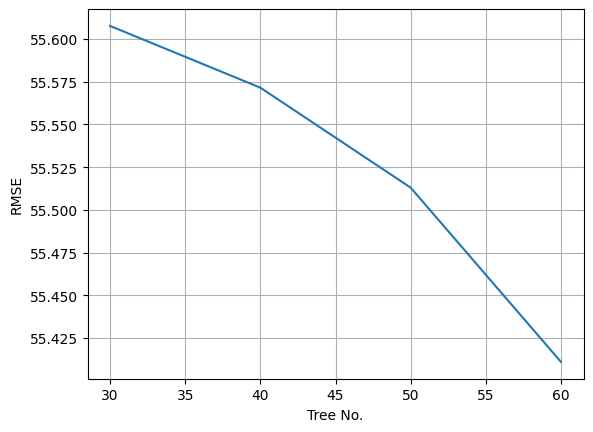

In [539]:
plt.plot(num_trees, rmse_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')
plt.grid()

In [540]:
pd.DataFrame( zip( rmse_results, std_results, ) )

,0,1
0,55.607682,1.761074
1,55.571538,1.678701
2,55.513039,1.661210
3,55.411056,1.512150


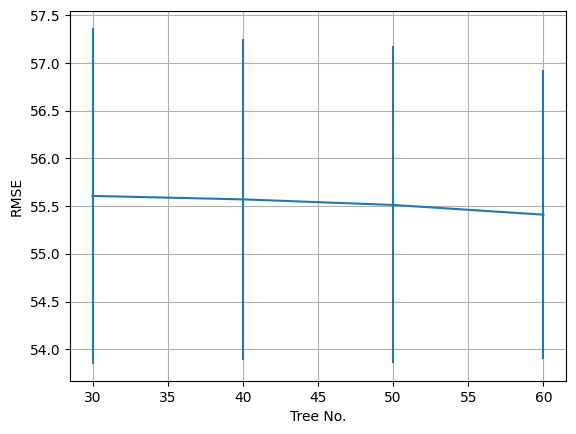

In [541]:
# plt.errorbar(num_trees, rmse_results, yerr=(std_results*2,std_results*2))
plt.errorbar(num_trees, rmse_results, yerr=std_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')

plt.grid()

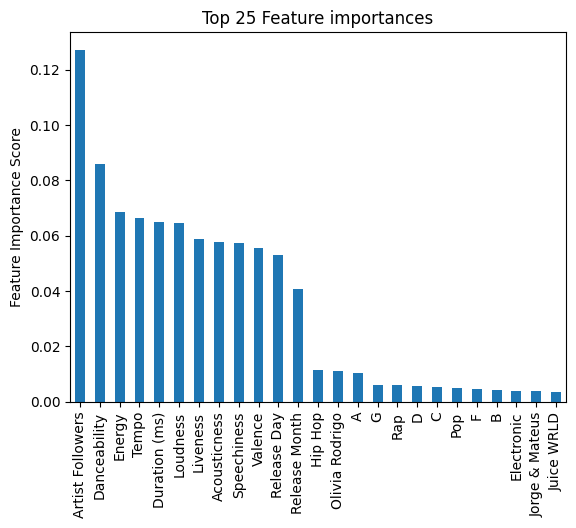

In [542]:
importances = rfModel.feature_importances_
forest_importances = pd.Series( importances, index = X.columns )

# top 25 features
top_forest_importances = forest_importances.sort_values( ascending = False ).head(25)

plt.figure()
# forest_importances.plot.bar()
top_forest_importances.sort_values( ascending = False ).plot.bar()
plt.title("Top 25 Feature importances")
plt.ylabel('Feature Importance Score') ;


###Random Forest (top features)

Let's try only using the features with the highest importance.

In [543]:
# order importances in top forest importances
top_forest_importances.sort_values( ascending = False )

# call df of top 6 features
forest_importances = pd.DataFrame(top_forest_importances)
forest_importances_6 = forest_importances.head(6).copy()
forest_importances_6


,0
Artist Followers,0.127186
Danceability,0.085826
Energy,0.068381
Tempo,0.066187
Duration (ms),0.064954
Loudness,0.064705


In [544]:
# make new df with top features and highest charting position
spotify_trimmed = spotify['Highest Charting Position']
spotify_trimmed = pd.concat([spotify_trimmed, spotify_encoded[forest_importances_6.index]], axis=1)
spotify_trimmed.head()

,Highest Charting Position,Artist Followers,Danceability,Energy,Tempo,Duration (ms),Loudness
0,1,3377762.0,0.714,0.800,134.002,211560.0,-4.808
1,2,2230022.0,0.591,0.764,169.928,141806.0,-5.484
2,1,6266514.0,0.563,0.664,166.928,178147.0,-5.044
3,3,83293380.0,0.808,0.897,126.026,231041.0,-3.712
4,5,5473565.0,0.736,0.704,149.995,212000.0,-7.409


In [545]:
# call X and y
X = spotify_trimmed.drop(columns=['Highest Charting Position'])
y = spotify_trimmed['Highest Charting Position']

In [553]:
numLoops = 500

mean_error = np.zeros(numLoops)

np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor(max_depth=4, random_state=0)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  mean_error[idx] = mean_squared_error(y_test, y_pred)

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')

RMSE: 57.32409834611467
RMSE_std: 1.660192586645483


In [547]:
# two parameters - n_estimators (number of trees), max_depth (number of splits)
numLoops = 500

mean_error = np.zeros(numLoops)

# np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )
  model = RandomForestRegressor( n_estimators = 10 )
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  mean_error[idx] = mean_squared_error( y_test, y_pred )

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')
np.sqrt(mean_error)[:50]


RMSE: 58.58268501332208
RMSE_std: 1.866782013136062


array([55.53044557, 60.97449128, 59.79897808, 59.49992642, 58.03173252,
       56.02162203, 61.09653123, 59.86465939, 54.82611078, 58.94784254,
       58.80516   , 58.28298429, 60.33800084, 54.90070152, 59.37761479,
       58.92547784, 59.14230522, 54.6229681 , 59.09400503, 59.68788835,
       58.17826664, 55.98199043, 59.26435253, 59.22638757, 60.82214222,
       58.33607991, 57.14231854, 59.97842464, 60.11595131, 58.06646476,
       58.18456081, 56.65548305, 60.69157718, 58.91151267, 57.56995985,
       62.47162703, 61.4153565 , 57.87609038, 56.83958078, 57.40031814,
       58.2600308 , 58.86650048, 54.72249289, 59.66730755, 61.33998625,
       58.23009916, 58.72296582, 61.00569667, 57.39141235, 59.23620523])

In [548]:
num_trees = range(30,110,10)
cv_loops = 100
rmse_results = np.zeros(len(num_trees))
std_results = np.zeros(len(num_trees))

for n, trees in enumerate(num_trees):
  rmse_cv = np.zeros(cv_loops)
  np.random.seed(42)
  for i in range(cv_loops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
    rfModel = RandomForestRegressor( n_estimators=trees )
    rfModel.fit(X_train, y_train)
    y_pred_rf = rfModel.predict(X_test)
    rmse_cv[i] = np.sqrt(mean_squared_error(y_test, y_pred_rf))

  print(trees,' trees finished.')
  rmse_results[n] = rmse_cv.mean()
  std_results[n] = rmse_cv.std()


30  trees finished.
40  trees finished.
50  trees finished.
60  trees finished.
70  trees finished.
80  trees finished.
90  trees finished.
100  trees finished.


In [549]:
pickle.dump(rfModel, open('rfModel.p','wb'))


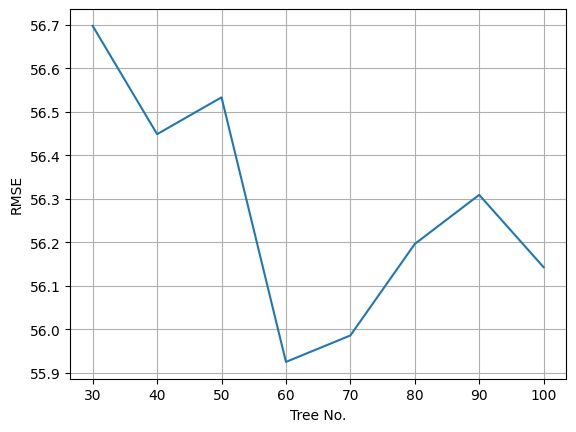

In [550]:
plt.plot(num_trees, rmse_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')
plt.grid()

In [551]:
pd.DataFrame( zip( rmse_results, std_results, ) )


,0,1
0,56.697101,1.664481
1,56.448245,1.709324
2,56.532959,1.753805
3,55.924644,1.521945
4,55.985432,1.449629
5,56.195815,1.642422
6,56.308697,1.588238
7,56.142368,1.601588


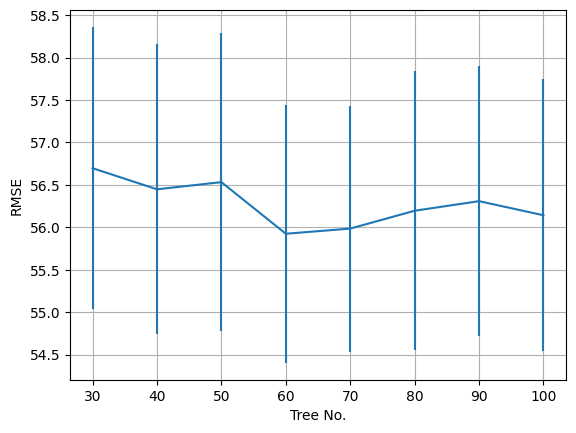

In [552]:
# plt.errorbar(num_trees, rmse_results, yerr=(std_results*2,std_results*2))
plt.errorbar(num_trees, rmse_results, yerr=std_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')

plt.grid()


# Conclusions

Overall, my RMSE score did not vary much between the different iterations of my random forest models using different groupings of features. Overall my RMSE was 55-56, from a relative scale of 1 (most popular) to 200 (least popular)
Next time, I would like to try more tree-based models like decision trees and XGBoost. I can also try using different data columns for measuring success, like streams or times charted.